## Sanity Checks

This is a little notebook with some sanity checks.
Proper tests are in [tests/](./tests/).
This notebook is just to visually look at how the simulation behaves.
Note, there might be some extra libraries used here, which are not mentioned anywhere else.

In [1]:
from itertools import product, combinations
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from magicsoup.examples.wood_ljungdahl import MOLECULES, REACTIONS, co2, formiat, formylFH4, NADPH, NADP, methylenFH4

theme_set(theme_minimal())
CHEMISTRY = ms.Chemistry(molecules=MOLECULES, reactions=REACTIONS)

### Genome Sizes

I would expect overall more coding regions (CDSs) and thus more proteins in larger genomes.
However, the likelihood of encountering a stop codon (in-frame) should stay the same.
So, the average CDS length and thus the expected number of domains per protein should not grow with larger genomes.

In [2]:
genetics = ms.Genetics(chemistry=CHEMISTRY)
records = []
for size in (100, 200, 300, 400, 500, 1000):
    for _ in range(1000):
        genome = ms.random_genome(s=size)
        proteins = genetics.get_proteome(seq=genome)
        records.append({
            "size": size,
            "n": len(proteins),
            "v": "proteins/genome"
        })
        if len(proteins) > 0:
            records.append({
                "size": size,
                "n": sum(len(d.domains) for d in proteins) / len(proteins),
                "v": "domains/protein"
            })
df = pd.DataFrame.from_records(records)

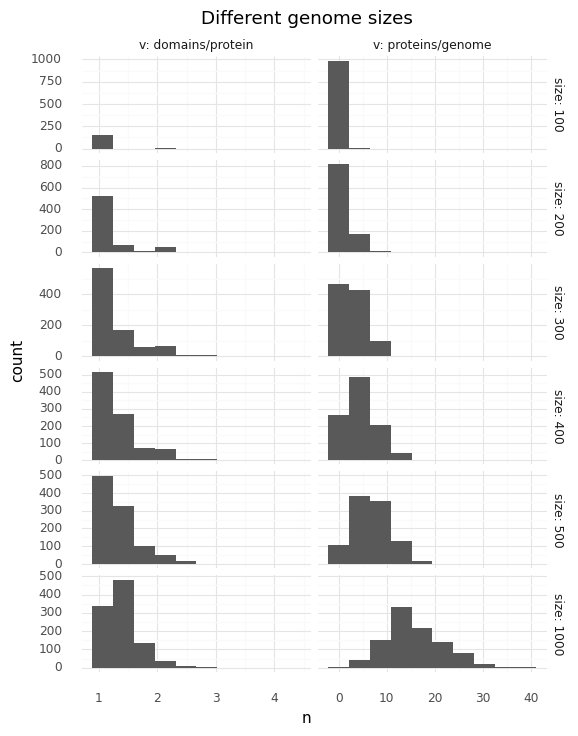

<ggplot: (8742232793582)>

In [3]:
(ggplot(df)
    + geom_histogram(aes(x="n"), bins=10)
    + facet_grid("size ~ v", scales="free", labeller="label_both")
    + theme(figure_size=(6, 8))
    + ggtitle("Different genome sizes"))

### Molecule Diffusion and Degradation

Below, I just want to see on a small map whether diffusion and degradation looks correct (_e.g._ using the circular map).
The diffusion coefficients and half lifes are what I would expect to be realistic values.
It would also be nice to see that differences in diffusion with different diffusion coefficients, and differences in degradation with different half lifes
actually make a visible difference.

In [4]:
ma = ms.Molecule("A", 10, diff_coef=1e-6, half_life=100_000)
mb = ms.Molecule("B", 10, diff_coef=1e-7, half_life=10_000)
mc = ms.Molecule("C", 10, diff_coef=1e-8, half_life=1_000)
molecules = [ma, mb, mc]

chemistry = ms.Chemistry(molecules=molecules, reactions=[])
world = ms.World(chemistry=chemistry, map_size=9, mol_map_init="zeros")
world.molecule_map[:, 4, 4] = 10.0
world.molecule_map[:, 5, 5] = 10.0
world.molecule_map[:, 8, 8] = 10.0

records = []
for si in range(10):
    for mi, mol in enumerate(molecules):
        for x, y in product(range(9), range(9)):
            records.append({
                "step": si,
                "mol": mol.name,
                "x": x,
                "y": y,
                "c": world.molecule_map[mi, x, y].item()
            })
    world.diffuse_molecules()
    world.degrade_molecules()
df = pd.DataFrame.from_records(records)

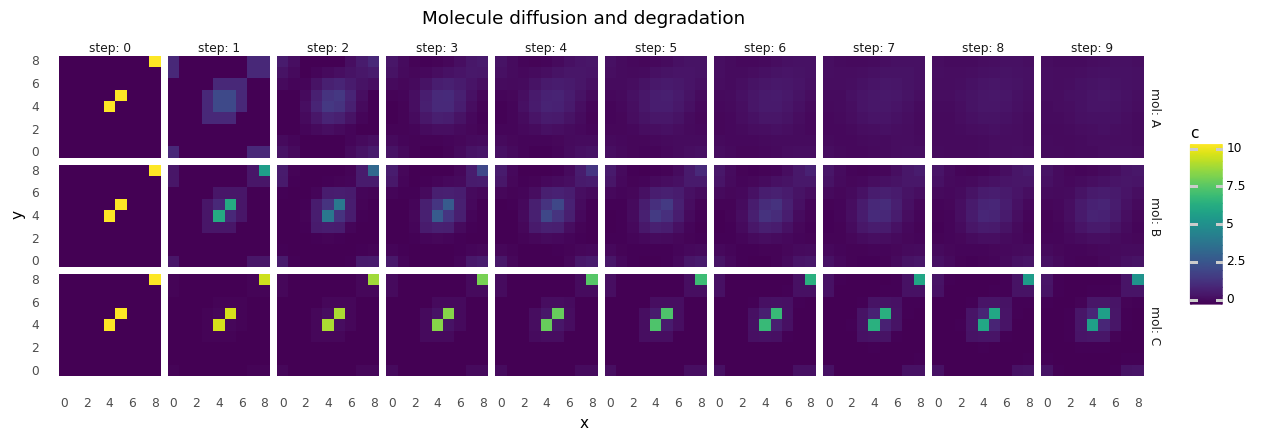

<ggplot: (8742232813987)>

In [5]:
(ggplot(df)
    + geom_tile(aes(x="x", y="y", fill="c"))
    + facet_grid("mol ~ step", labeller="label_both")
    + coord_equal(expand=False)
    + theme(figure_size=(14, 6))
    + ggtitle("Molecule diffusion and degradation"))

## Equilibrium Constants

Any reaction always moved into the direction of lowering Gibb's free energy $\Delta G = \Delta G_0 + RT \ln Q$.
This term is influenced by the internal energy difference of the reaction's substrates and products $\Delta G_0$, and by the change in entropy which can be expressed as a function of the reaction quotient $R \ln Q$.
At equilibrium these 2 terms cancel each other out $\Delta G_0 = RT \ln K_e$.
Thus, looking at the equilibrium constants $K_e$ of this simulation is good to see how favourable certain reactions are, or how much concentration gradients will influence the reaction.

For reactions such as $NADPH \rightleftharpoons NADP^- + H^+$ I expect large $K_e$. However, the majority of $K_e$ should not be too far away from 1.0.
Otherwise, cells could not make any use of concentration gradients to gain energy.
Below, I look at each defined reaction separately.
Then, I am also looking at what reactions are catalyzed by proteins from random genomes.

In [6]:
world = ms.World(chemistry=CHEMISTRY)

records = []
for subs, prods in REACTIONS:
    name = " + ".join(str(d) for d in subs) + " <-> " + " + ".join(str(d) for d in prods)
    energy = sum(d.energy for d in prods) - sum(d.energy for d in subs)
    ke = math.exp(-energy / (GAS_CONSTANT * world.abs_temp))
    records.append({"name": name, "Ke": ke})

genomes = [ms.random_genome(s=300) for _ in range(100)]
world.add_random_cells(genomes=genomes)
for cell in world.cells:
    for protein in cell.proteome:
        energy = 0.0
        for dom in protein.domains:
            if dom.is_catalytic:
                energy -= sum(d.energy for d in dom.substrates)
                energy += sum(d.energy for d in dom.products)
        ke = math.exp(-energy / (GAS_CONSTANT * world.abs_temp))
        records.append({"name": "random proteins", "Ke": ke})

df = pd.DataFrame.from_records(records)

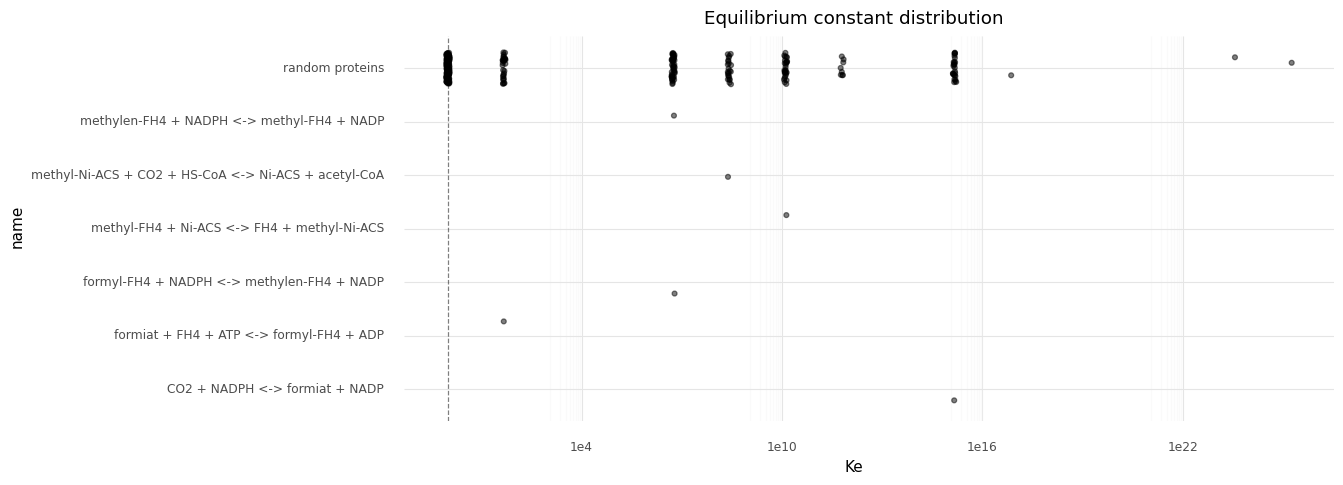

<ggplot: (8742229782194)>

In [7]:
(ggplot(df, aes(x="name", y="Ke"))
    + geom_hline(yintercept=1.0, linetype="dashed", alpha=.5)
    + geom_jitter(data=df, alpha=.5, width=.3, height=.05)
    + scale_y_log10()
    + coord_flip()
    + theme(figure_size=(12, 5))
    + ggtitle("Equilibrium constant distribution"))

### Working Cell

Below I want to see how a cell actually starts to work and change its environment.
I currently don't have a clever way of defining a cell other than just assigning a genome.
So, the resulting cell is completely random.

First, a plot showing how the cell changes its environment over time.
Molecules suffixed with `[i]` are the intracellular molecule species, ones suffixed with `[e]` are the extracellular one
(on the pixel the cell lives on).

Second, networks depicting this cell's proteome.
To reduce the clutter I am plotting each protein one by one as a single network, instead of showing all proteins as a single network.
The protein itself is always the gray middle node with its size being proportional to $V_{Max}$.
Arrows point to and from substrates/products and effectors.
Substrates and product arrows are gray, inhibiting effectors are red, activating effectors are green.
Arrow widths are proportional to $K_M^{-1}$.
Intracellular molecules are blue, extracellular ones orange.

In [8]:
world = ms.World(chemistry=CHEMISTRY)
world.molecule_map *= 100
while True:
    world.add_random_cells(genomes=[ms.random_genome(s=300)])
    if len(world.cells[0].proteome) >= 10:
        break
    world.kill_cells(cell_idxs=[0])

cell = world.cells[0]
for protein in cell.proteome:
    print(f"{protein}: {', '.join(str(d) for d in protein.domains)}")

P0: TransporterDomain(NADP,outwards)
P1: TransporterDomain(NADP,outwards)
P2: TransporterDomain(acetyl-CoA,inwards), TransporterDomain(methylen-FH4,inwards), ReceptorDomain(FH4,transmembrane,inhibiting)
P3: TransporterDomain(acetyl-CoA,inwards), TransporterDomain(methylen-FH4,inwards), ReceptorDomain(FH4,transmembrane,inhibiting)
P4: CatalyticDomain(methyl-Ni-ACS,HS-CoA,CO2->acetyl-CoA,Ni-ACS)
P5: TransporterDomain(methylen-FH4,inwards), ReceptorDomain(FH4,transmembrane,inhibiting)
P6: CatalyticDomain(methyl-Ni-ACS,HS-CoA,CO2->acetyl-CoA,Ni-ACS)
P7: CatalyticDomain(methyl-Ni-ACS,HS-CoA,CO2->acetyl-CoA,Ni-ACS)
P8: CatalyticDomain(methyl-Ni-ACS,HS-CoA,CO2->acetyl-CoA,Ni-ACS)
P9: CatalyticDomain(methyl-Ni-ACS,HS-CoA,CO2->acetyl-CoA,Ni-ACS)
P10: TransporterDomain(NADP,outwards)


In [10]:
records = []
for si in range(40):
    for idx, mol in enumerate(MOLECULES):
        records.append({
            "step": si,
            "molecule": f"{mol.name}[i]",
            "c": world.cell_molecules[0, idx].item()
        })
        records.append({
            "step": si,
            "molecule": f"{mol.name}[e]",
            "c": world.molecule_map[idx, cell.position[0], cell.position[1]].item()
        })
    world.enzymatic_activity()
    world.degrade_molecules()
    world.diffuse_molecules()
df = pd.DataFrame.from_records(records)

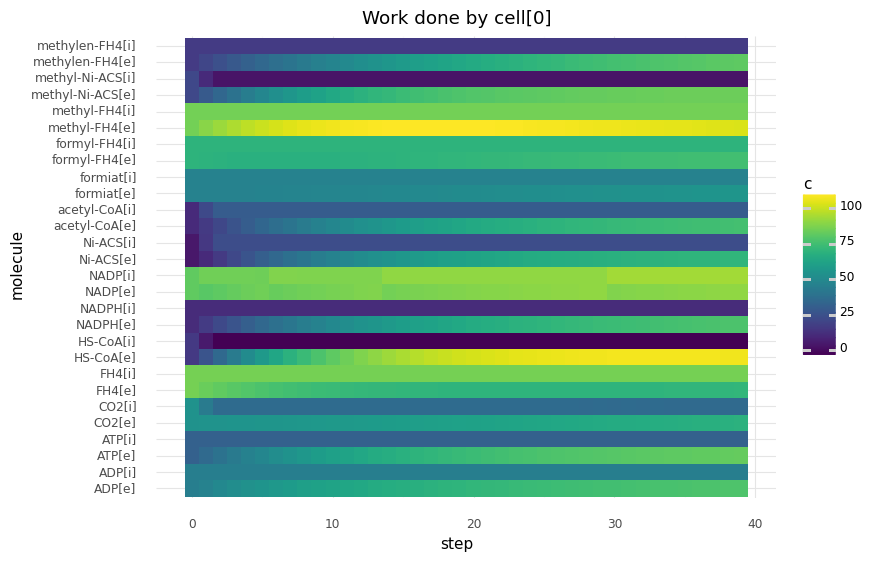

<ggplot: (8742217043800)>

In [11]:
(ggplot(df)
    + geom_tile(aes(x="step", y="molecule", fill="c"))
    + theme(figure_size=(8, 6))
    + ggtitle(f"Work done by cell[{cell.idx}]"))

In [12]:
graphs = []
for pi, protein in enumerate(cell.proteome):
    vs = []
    G = nx.DiGraph()
    for dom in protein.domains:
        kwargs = {
            "w": abs(1 / math.log(1 + dom.affinity)),
            "c": "gray"
        }
        if dom.is_catalytic:
            vs.append(dom.velocity)
            suffix = "[e]" if dom.is_transmembrane else "[i]"
            for mol in dom.substrates:
                G.add_edge(f"{mol.name}{suffix}", "", **kwargs)
            for mol in dom.products:
                G.add_edge("", f"{mol.name}{suffix}", **kwargs)
        if dom.is_transporter:
            vs.append(dom.velocity)
            mol = dom.substrates[0]
            G.add_edge(f"{mol.name}[i]", "", **kwargs)
            G.add_edge("", f"{mol.name}[e]", **kwargs)
        if dom.is_regulatory:
            kwargs["c"] = "r" if dom.is_inhibiting else "g"
            suffix = "[e]" if dom.is_transmembrane else "[i]"
            G.add_edge(f"{mol.name}{suffix}", "", **kwargs)
    
    for key, val in G.nodes.items():
        if key == "":
            val["s"] = sum(vs) / len(vs) if len(vs) > 0 else 1e-2
            val["c"] = "gray"
        else:
            val["s"] = 1e-1
            val["c"] = "orange" if key.endswith("[e]") else "blue"
        val["s"] = math.log(1 + val["s"])

    graphs.append(G)

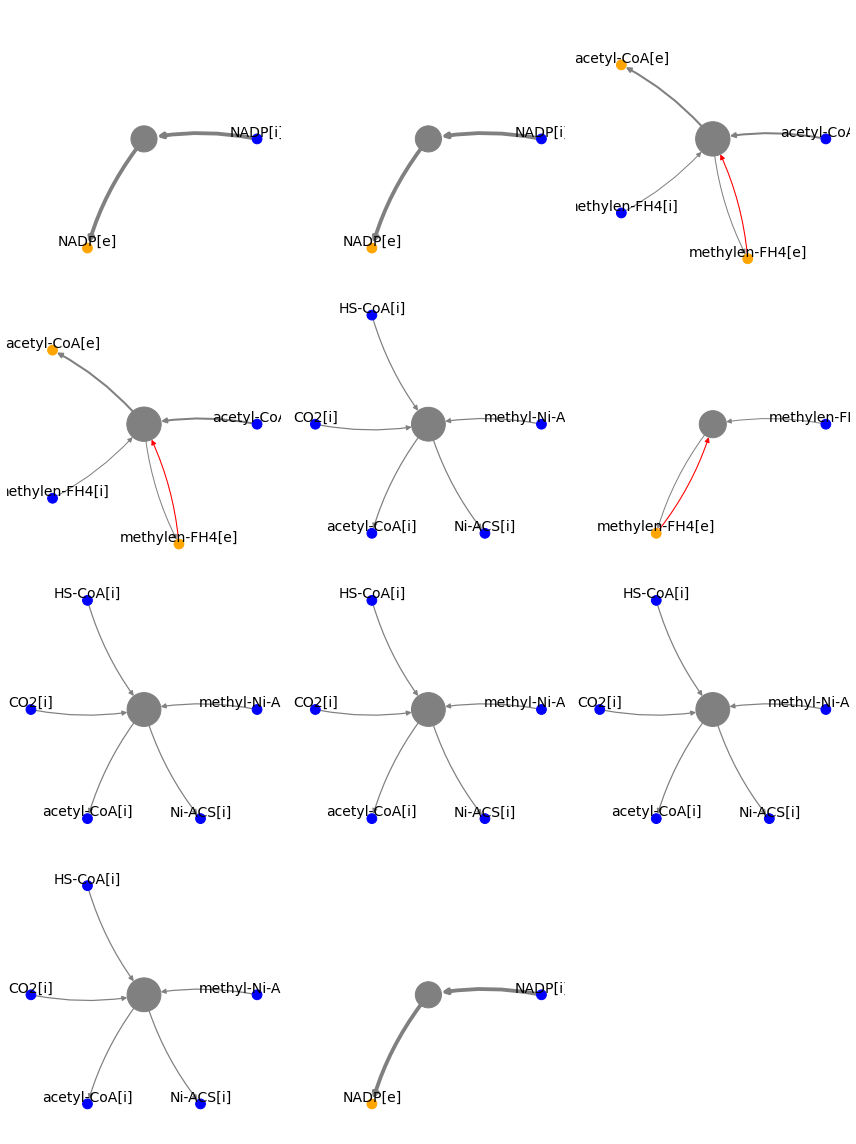

In [13]:
n_cols = 3
n_rows = int(math.ceil(len(graphs) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(n_cols * 4, n_rows * 4))

for plot_i, ax in enumerate(axs.flat):
    ax.axis("off")
    
    if plot_i < len(graphs):
        G = graphs[plot_i]
    
        pos = nx.circular_layout(G, center=(0, 0))
        pos[""] = (0, 0)
        
        edgewidths = [G.get_edge_data(u, v)["w"] * 1e-4 + 1 for u, v in G.edges()]
        nodesizes = [v["s"] * 1e3 for v in G.nodes.values()]
        edgecols = [G.get_edge_data(u, v)["c"] for u, v in G.edges()]
        nodecols = [v["c"] for v in G.nodes.values()]

        nx.draw(
            G, pos, ax=ax,
            node_size=nodesizes,
            node_color=nodecols,
            width=edgewidths,
            edge_color=edgecols,
            connectionstyle="arc3,rad=0.1",
            
        )

        nx.draw_networkx_labels(G, pos, ax=ax, font_size=14, verticalalignment="bottom")
        ax.margins(0.1, 0.05)

fig.tight_layout()
plt.show()

## Free Energy in Simulation

Cells can make use of the internal energy of molecules and concentration differences of molecules to drive reactions.
While doing that, and while molecules are allowed to diffuse, the overall available free Gibb's energy of the world decreases.
So, without regular energy supply cells will eventually all die and molecules will be spread equally over the map.

I want to see how entropy $\Delta S$, enthalpie $\Delta H$, and Gibb's free energy $\Delta G$ evolve over time.
Since there is no volume or pressure dependent work $\Delta H = \Delta U$, the internal energy of molecules.
Thus, in this simulation Gibb's free energy depends on internal energy and entropy $\Delta G = \Delta U - T \Delta S$.

In this simulation there is no concept of temperature defined for internal energies of molecules.
It is only the energy from chemical bonds that makes up the internal energy of any molecule.
This has been defined in the beginning of the simulation and I can just sum up these energies $U = \sum_i \sum_j n_i U_j$
for every position $i$ and every molecule $j$ where $n_i$ is the number of molecules at position $i$ and $U_j$ is the internal energy of molecule $j$.
Positions are pixels on `molecule_map`, and intracellular pixels represented by `cell_molecules`.

Entropy calculation is a bit less straight forward. 
I approximating entropy using the Sackur–Tetrode equation as basis. 
Its 1D version would be $S = R N ( \ln \frac{l}{N} + \ln \sqrt{\frac{U}{N}} + \varepsilon)$ where $N$ is the number of molecules,
$U$ is their internal energy, $l$ is the interval length over which these molecules are in a thermodynamic equilibrium, and $\varepsilon$
summarizes the terms for momenta uncertainty and the quantum mechanical uncertainty principle. 
This entropy definition is extensive, so I must not change the number of molecules during the simulation. 
Thus, I am only defining a subset of reactions in this simulation. 
With that I can define an interval to be a single position and then calculate entropy with
$S = R \sum_i \sum_j ( \ln \frac{1}{n_i} + \ln \sqrt{\frac{U_j}{n_i}} + \varepsilon)$. 
Since I am only interested in $\Delta S$ and the number of molecules is held constant I can neglect $\varepsilon$.

In [2]:
def init_world() -> ms.World:
    ms.Molecule._instances = {}
    energies = [d * 1e3 for d in (100, 200, 300)]
    molecules = [ms.Molecule(str(i), d) for i, d in enumerate(energies)]
    reactions = [([a], [b]) for a, b in combinations(molecules, 2)]
    chemistry = ms.Chemistry(molecules=molecules, reactions=reactions)
    world = ms.World(chemistry=chemistry)
    world.molecule_map = (world.molecule_map + 2.0) * 5.0
    world.add_random_cells(genomes=[ms.random_genome(s=300) for _ in range(1000)])
    return world

def energy(t: torch.Tensor, e: float) -> float:
    return torch.sum(t * e).item()

def world_energy(world: ms.World) -> float:
    molecules = world.genetics.chemistry.molecules
    on_map = [energy(world.molecule_map[i], d.energy) for i, d in enumerate(molecules)]
    in_cells = [energy(world.cell_molecules[:, i], d.energy) for i, d in enumerate(molecules)]
    return sum(on_map) + sum(in_cells)

def entropy(t: torch.Tensor, e: float) -> float:
    x = t[t > 0.0]
    return GAS_CONSTANT * torch.sum(x * (torch.log(1 / x) * torch.log((e / x) ** (1/2)))).item()

def world_entropy(world: ms.World) -> float:
    molecules = world.genetics.chemistry.molecules
    on_map = [entropy(world.molecule_map[i], d.energy) for i, d in enumerate(molecules)]
    in_cells = [entropy(world.cell_molecules[:, i], d.energy) for i, d in enumerate(molecules)]
    return sum(on_map) + sum(in_cells)

records = []
n_steps = 100

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.diffuse_molecules()
    records.append({
        "label": "diffusion",
        "step": step_i,
        "dU": world_energy(world) - U0,
        "dS": world_entropy(world) - S0,
        "n": world.molecule_map.sum().item() + world.cell_molecules.sum().item()
    })

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.enzymatic_activity()
    records.append({
        "label": "enzymatic-activity",
        "step": step_i,
        "dU": world_energy(world) - U0,
        "dS": world_entropy(world) - S0,
        "n": world.molecule_map.sum().item() + world.cell_molecules.sum().item()
    })

world = init_world()
U0 = world_energy(world)
S0 = world_entropy(world)
for step_i in range(n_steps):
    world.enzymatic_activity()
    world.diffuse_molecules()
    records.append({
        "label": "both",
        "step": step_i,
        "dU": world_energy(world) - U0,
        "dS": world_entropy(world) - S0,
        "n": world.molecule_map.sum().item() + world.cell_molecules.sum().item()
    })

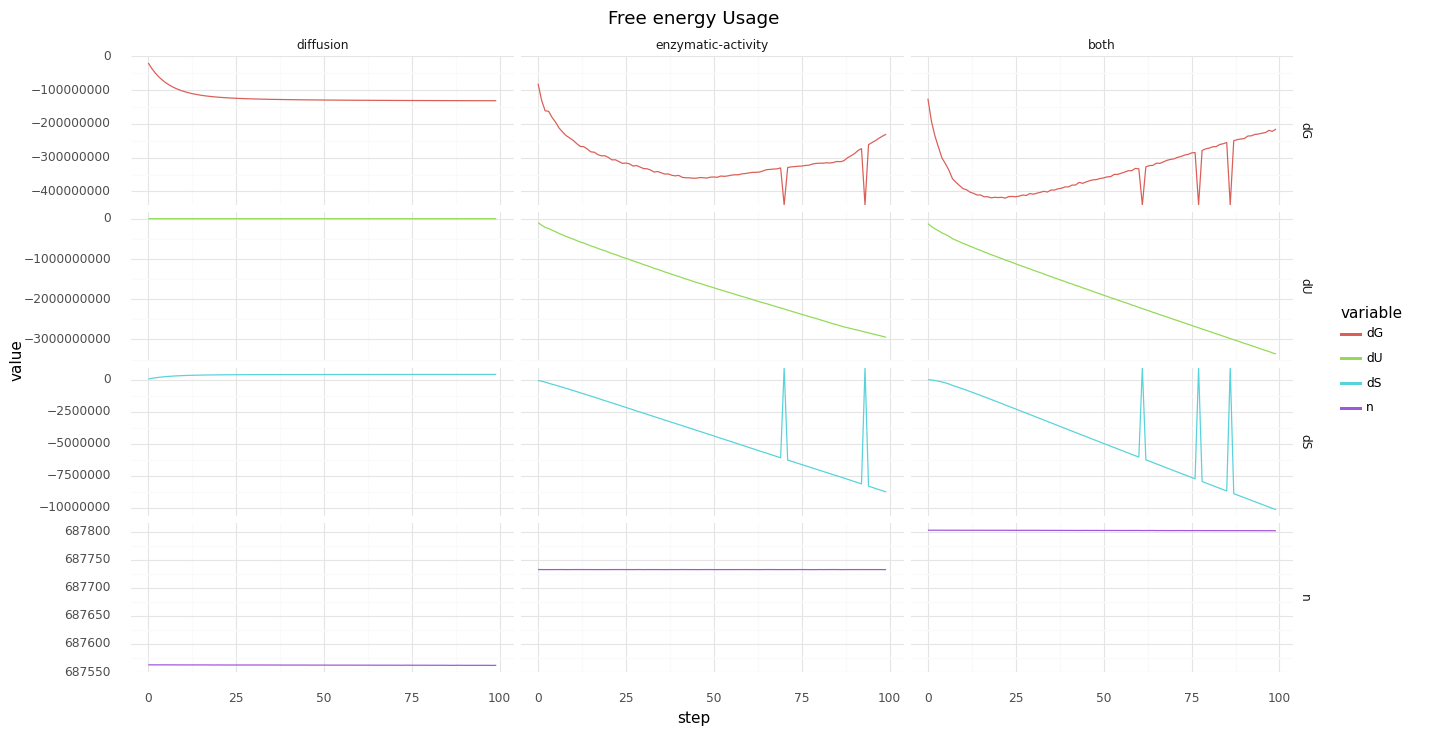

<ggplot: (8773759024369)>

In [3]:
df = pd.DataFrame.from_records(records)
df["dG"] = df["dU"] - df["dS"] * world.abs_temp
df = df.melt(id_vars=["step", "label"], value_vars=["dG", "dU", "dS", "n"])
df["variable"] = pd.Categorical(df["variable"], categories=["dG", "dU", "dS", "n"])
df["label"] = pd.Categorical(df["label"], categories=["diffusion", "enzymatic-activity", "both"])

(ggplot(df)
    + geom_line(aes(x="step", y="value", color="variable"))
    + theme(figure_size=(15, 8))
    + facet_grid("variable ~ label", scales="free")
    + ggtitle("Free energy Usage"))